<a href="https://colab.research.google.com/github/farhan1503001/Satelite-Image-Segmentation/blob/main/DeepLabV3%2B_ResNet_Backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import  Conv2D,BatchNormalization,UpSampling2D,Concatenate,Activation,AveragePooling2D
import os
from tensorflow.keras.layers import Input,Conv2DTranspose
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

**DeepLabV3Plus**

> Indented block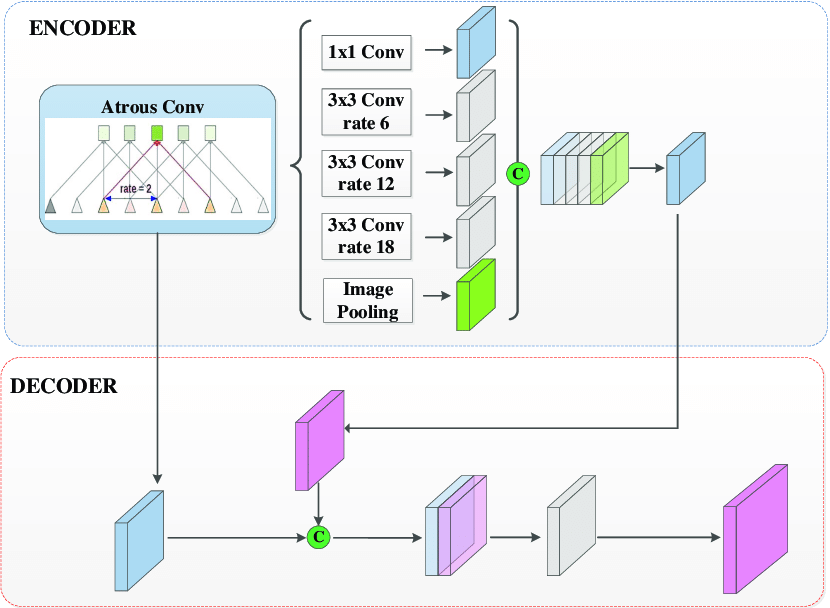



In [ ]:
#Pyramid pooling aspp
#image_pooling->1d conv-->dilated conv with b8=>16=>32
def ASPP(inputs):
  #First entire shape pooling
  shape=inputs.shape
  y_pool=AveragePooling2D(pool_size=(shape[1],shape[2]),name='average_pooling')(inputs)
  y_pool=Conv2D(filters=256,kernel_size=1,use_bias=False,padding='same')(y_pool)
  y_pool=BatchNormalization()(y_pool)
  y_pool=Activation(activation='relu')(y_pool)
  y_pool=UpSampling2D(size=(shape[1],shape[2]),interpolation='bilinear')(y_pool)
  #print(y_pool.shape)

  #Now 1-d Channelwise convolution
  y_1=Conv2D(filters=256,kernel_size=1,use_bias=False,padding='same',dilation_rate=1)(inputs)
  y_1=BatchNormalization()(y_1)
  y_1=Activation(activation='relu')(y_1)
  #Now with dilationrate=6
  y_6=Conv2D(filters=256,kernel_size=3,use_bias=False,padding='same',dilation_rate=6)(inputs)
  y_6=BatchNormalization()(y_6)
  y_6=Activation(activation='relu')(y_6)

  #Now with dilationrate=12
  y_12=Conv2D(filters=256,kernel_size=3,use_bias=False,padding='same',dilation_rate=12)(inputs)
  y_12=BatchNormalization()(y_12)
  y_12=Activation(activation='relu')(y_12)

  #Now with dilation rate=18
  y_18=Conv2D(filters=256,kernel_size=3,use_bias=False,padding='same',dilation_rate=18)(inputs)
  y_18=BatchNormalization()(y_18)
  y_18=Activation(activation='relu')(y_18)

  y=Concatenate()([y_pool,y_1,y_6,y_12,y_18])
  #1-d convolution application
  y=Conv2D(filters=256,kernel_size=1,padding='same',dilation_rate=1,use_bias=False)(y)
  y=BatchNormalization()(y)
  y=Activation(activation='relu')(y)
  #print(y.shape)
  return y


In [ ]:
def DeepLabv3plus(shape):
  """
  input shape is given as a tuple generate a deeplabv3 model
  """
  input=Input(shape)
  base_model=ResNet50(include_top=False,weights='imagenet',input_tensor=input)

  image_features=base_model.get_layer('conv4_block6_out').output

  #Now we will perform atrous asymmetric pyramid pooling
  x_a=ASPP(image_features)
  x_a=UpSampling2D(size=(4,4),interpolation='bilinear')(x_a)
  #Now we will get low level features from our resnet model
  x_b=base_model.get_layer('conv2_block2_out').output
  print(x_b.shape)
  x_b=Conv2D(filters=48,kernel_size=1,padding='same',use_bias=False)(x_b)
  x_b=BatchNormalization()(x_b)
  x_b=Activation(activation='relu')(x_b)
  print(x_b.shape)
  #Now we will concatenate
  x=Concatenate()([x_a,x_b])
  #print(x.shape)
  #Now apply convolutional layer with 3*3 filter 2 times
  x=Conv2D(filters=256,kernel_size=1,padding='same',use_bias=False)(x)
  x=BatchNormalization()(x)
  x=Activation(activation='relu')(x)

  x=Conv2D(filters=256,kernel_size=1,padding='same',use_bias=False)(x)
  x-BatchNormalization()(x)
  x=Activation(activation='relu')(x)

  x=UpSampling2D(size=(4,4),interpolation='bilinear')(x)
  #print(x.shape)
  #outputs
  x=Conv2D(1,(1,1),name='output_layer')(x)
  x=Activation(activation='sigmoid')(x)
  #print(x.shape)
  #Model
  model=Model(inputs=input,outputs=x)
  return model

In [ ]:
if __name__=='__main__':
  shape=(256,256,3)
  model=DeepLabv3plus(shape)
  #model.summary()

(None, 64, 64, 256)
(None, 64, 64, 48)


In [ ]:
a_model=ResNet50(include_top=False,weights='imagenet',input_shape=(256,256,3))
a_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_21[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           